Installing Libraries

In [1]:
!pip -q install yfinance pandas numpy matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Imports and Settings

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path(r"D:\python task\Task 1\Dataset")
print("Dataset folder exists:", DATA_DIR.exists())

files = list(DATA_DIR.glob("*"))
print("Files in folder:")
for f in files:
    print(" -", f.name)

Dataset folder exists: True
Files in folder:
 - Prices.csv


In [ ]:
prices_csv = DATA_DIR / "Prices.csv" 
df_wide = pd.read_csv(prices_csv)
print("Shape:", df_wide.shape)
df_wide.head()

Shape: (2765, 11)


,Date,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
0,2015-01-02,24.237549,15.4260,26.278944,76.955551,46.511124,77.905800,39.858452,0.483011,66.518349,57.916889
1,2015-01-05,23.554735,15.1095,25.778227,76.418083,45.067196,76.654541,39.491920,0.474853,66.202065,56.332203
2,2015-01-06,23.556952,14.7645,25.142035,76.042580,43.898651,75.621750,38.912289,0.460457,65.900513,56.032726
3,2015-01-07,23.887281,14.9210,25.068092,77.721291,43.965630,75.621750,39.406689,0.459257,66.246216,56.600468
4,2015-01-08,24.805077,15.0230,25.155436,78.332405,44.948116,77.637688,40.565952,0.476533,67.003761,57.542580


In [ ]:
import math
from dataclasses import dataclass

@dataclass
class Trade:
    entry_date: pd.Timestamp
    entry_price: float
    exit_date: pd.Timestamp
    exit_price: float
    shares: int
    pnl: float
    forced_exit: bool


class GoldenCrossStrategy:
    """
    Golden Cross strategy on a single symbol:
    - Buy when MA50 crosses above MA200
    - Sell when MA50 crosses below MA200
    - Budget: $5000, all-in position sizing
    - Only one position at a time
    - Force close at final row if still open
    """
    def __init__(self, symbol: str, start: str, end: str, budget: float = 5000.0, prices_wide_df: pd.DataFrame = None):
        self.symbol = symbol.upper()
        self.start = pd.to_datetime(start)
        self.end = pd.to_datetime(end)
        self.budget = float(budget)
        self.wide = prices_wide_df

        self.df = None
        self.trades = []
        self.final_cash = None

    def load_from_kaggle_wide(self):
        if self.wide is None:
            raise ValueError("prices_wide_df is None. Pass df_wide into the class.")

        df = self.wide.copy()

        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")

        df = df[(df["Date"] >= self.start) & (df["Date"] <= self.end)].copy()

        if self.symbol not in df.columns:
            sample_cols = [c for c in df.columns[:15]]
            raise ValueError(f"Symbol '{self.symbol}' not found in dataset columns. Example columns: {sample_cols}")


        out = df[["Date", self.symbol]].rename(columns={self.symbol: "Close"})
        out = out.drop_duplicates(subset=["Date"], keep="first")  # duplicates removed
        out = out.set_index("Date")
        out["Close"] = pd.to_numeric(out["Close"], errors="coerce")

        out = out.ffill().dropna()

        self.df = out
        return self.df

    def add_indicators(self, ma_short=50, ma_long=200):
        df = self.df.copy()
        df["MA50"] = df["Close"].rolling(ma_short).mean()
        df["MA200"] = df["Close"].rolling(ma_long).mean()
        df = df.dropna() 
        self.df = df
        return self.df

    def add_signals(self):
        df = self.df.copy()
        df["golden_cross"] = (df["MA50"] > df["MA200"]) & (df["MA50"].shift(1) <= df["MA200"].shift(1))
        df["death_cross"] = (df["MA50"] < df["MA200"]) & (df["MA50"].shift(1) >= df["MA200"].shift(1))
        self.df = df
        return self.df

    def backtest(self):
        df = self.df.copy()

        cash = self.budget
        shares = 0
        entry_price = None
        entry_date = None
        trades = []

        for date, row in df.iterrows():
            price = float(row["Close"])

            if row["golden_cross"] and shares == 0:
                qty = int(cash // price)
                if qty > 0:
                    shares = qty
                    cash -= shares * price
                    entry_price = price
                    entry_date = date

            elif row["death_cross"] and shares > 0:
                cash += shares * price
                pnl = (price - entry_price) * shares
                trades.append(Trade(entry_date, entry_price, date, price, shares, pnl, False))
                shares = 0
                entry_price = None
                entry_date = None

        if shares > 0:
            last_date = df.index[-1]
            last_price = float(df.iloc[-1]["Close"])
            cash += shares * last_price
            pnl = (last_price - entry_price) * shares
            trades.append(Trade(entry_date, entry_price, last_date, last_price, shares, pnl, True))
            shares = 0

        self.trades = trades
        self.final_cash = cash
        return trades

    def trades_df(self):
        if not self.trades:
            return pd.DataFrame(columns=["EntryDate","EntryPrice","ExitDate","ExitPrice","Shares","PnL","ForcedExit"])
        return pd.DataFrame([{
            "EntryDate": t.entry_date,
            "EntryPrice": t.entry_price,
            "ExitDate": t.exit_date,
            "ExitPrice": t.exit_price,
            "Shares": t.shares,
            "PnL": t.pnl,
            "ForcedExit": t.forced_exit
        } for t in self.trades])

    def summary(self):
        tdf = self.trades_df()
        total_pnl = float(tdf["PnL"].sum()) if len(tdf) else 0.0
        final_value = float(self.final_cash) if self.final_cash is not None else None
        return_pct = ((final_value - self.budget) / self.budget * 100) if final_value is not None else None

        return {
            "Symbol": self.symbol,
            "Start": str(self.start.date()),
            "End": str(self.end.date()),
            "InitialBudget": self.budget,
            "Trades": len(tdf),
            "TotalPnL": total_pnl,
            "FinalPortfolioValue": final_value,
            "TotalReturnPct": return_pct
        }

    def plot(self):
        df = self.df.copy()
        plt.figure(figsize=(14,6))
        plt.plot(df.index, df["Close"], label="Close (Adj)")
        plt.plot(df.index, df["MA50"], label="MA50")
        plt.plot(df.index, df["MA200"], label="MA200")

        buys = df[df["golden_cross"]]
        sells = df[df["death_cross"]]
        plt.scatter(buys.index, buys["Close"], marker="^", label="Buy (Golden Cross)")
        plt.scatter(sells.index, sells["Close"], marker="v", label="Sell (Death Cross)")

        plt.title(f"{self.symbol} Golden Cross Strategy ($5000 budget)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.show()

In [5]:
strategy = GoldenCrossStrategy("AAPL", "2018-01-01", "2023-12-31", budget=5000, prices_wide_df=df_wide)
strategy

In [6]:
df = strategy.load_from_kaggle_wide()
print("Rows:", df.shape[0])
print("Date range:", df.index.min().date(), "to", df.index.max().date())
print("NaNs after ffill:", df.isna().sum().to_dict())
df.head()

Rows: 1509
Date range: 2018-01-02 to 2023-12-29
NaNs after ffill: {'Close': 0}


,Close
Date,
2018-01-02,40.341888
2018-01-03,40.334866
2018-01-04,40.522228
2018-01-05,40.983578
2018-01-08,40.831356


In [7]:
df = strategy.add_indicators(50, 200)
df[["Close","MA50","MA200"]].tail()

,Close,MA50,MA200
Date,,,
2023-12-22,191.788773,183.572862,176.609049
2023-12-26,191.243896,183.858867,176.832686
2023-12-27,191.342972,184.149426,177.047101
2023-12-28,191.768936,184.479570,177.253187
2023-12-29,190.728760,184.814830,177.452099


In [8]:
df = strategy.add_signals()

print("Golden crosses:", int(df["golden_cross"].sum()))
print("Death crosses:", int(df["death_cross"].sum()))

df[df["golden_cross"] | df["death_cross"]][["Close","MA50","MA200","golden_cross","death_cross"]].head(10)

Golden crosses: 3
Death crosses: 3


,Close,MA50,MA200,golden_cross,death_cross
Date,,,,,
2018-12-21,35.829693,45.732328,45.840088,False,True
2019-05-06,49.769855,45.818884,45.698824,True,False
2022-06-03,142.783844,156.103788,156.256706,False,True
2022-09-26,148.283279,157.515347,157.478583,True,False
2022-10-07,137.779419,156.048411,156.198539,False,True
2023-03-22,155.721725,145.707783,145.481216,True,False


In [9]:
strategy.backtest()
trades_df = strategy.trades_df()
trades_df

,EntryDate,EntryPrice,ExitDate,ExitPrice,Shares,PnL,ForcedExit
0,2019-05-06,49.769855,2022-06-03,142.783844,100,9301.398849,False
1,2022-09-26,148.283279,2022-10-07,137.779419,96,-1008.370605,False
2,2023-03-22,155.721725,2023-12-29,190.728760,85,2975.597916,True


In [10]:
strategy.summary()

{'Symbol': 'AAPL',
 'Start': '2018-01-01',
 'End': '2023-12-31',
 'InitialBudget': 5000.0,
 'Trades': 3,
 'TotalPnL': 11268.626159667969,
 'FinalPortfolioValue': 16268.626159667969,
 'TotalReturnPct': 225.3725231933594}

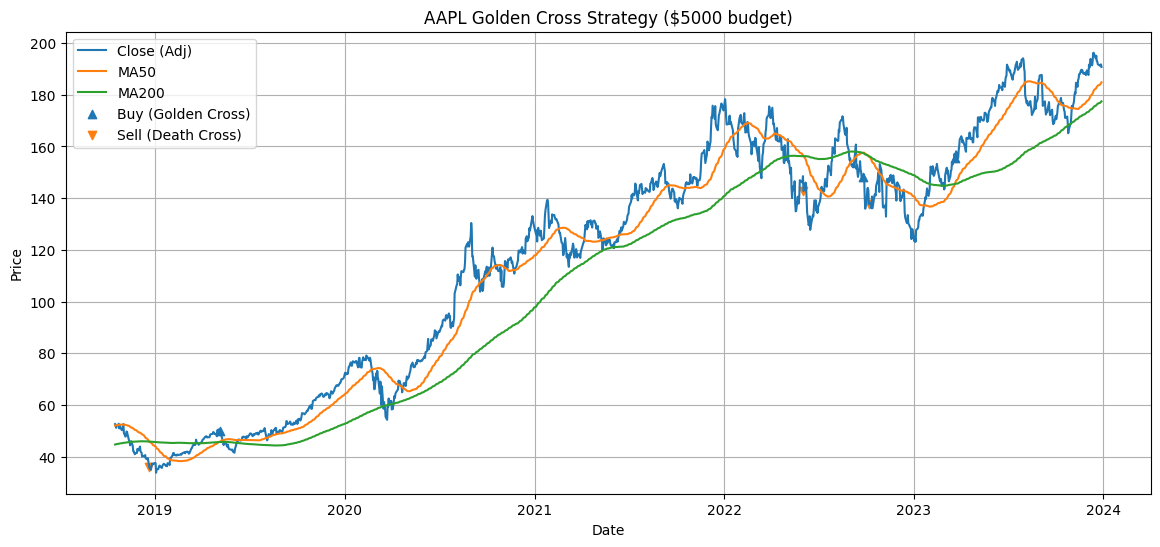

In [11]:
strategy.plot()